<a href="https://colab.research.google.com/github/marekpiotradamczyk/ml_uwr_22/blob/main/kmeans_deep_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How it differs from the default solution? 

Here we are using a neural network instead of a logreg

# Load data & default imports

In [26]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import scipy.stats as sstats
import multiprocessing as mp
from sklearn import datasets
import sklearn.linear_model
from tqdm.auto import tqdm
from matplotlib import animation, pyplot, rc
import matplotlib.pyplot as plt
import httpimport
from os.path import join
import os.path
from PIL import Image

from sklearn.cluster import KMeans, MiniBatchKMeans
import numpy as np

from sklearn.feature_extraction import image
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.linear_model import LogisticRegression

from FeaturesExtractor import FeaturesExtractor
from helpers import plot_history

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten

!pip install -q gdown httpimport
![ -e cifar.npz ] || gdown 'https://drive.google.com/uc?id=1oBzZdtg2zNTPGhbRy6DQ_wrf5L5OAhNR' -O cifar.npz

with np.load('cifar.npz') as data:
    X_trn = data['train_data']
    y_trn = data['train_labels']
    X_tst = data['test_data']
    y_tst = data['test_labels']

# testing

In [19]:
C          = -1
PATCH_SIZE = 4
PATCH_NUM  = 1000000
STRIDE     = 2
K          = 6

In [20]:
extractor = FeaturesExtractor(PATCH_SIZE, PATCH_NUM, STRIDE, K)

extractor.fit(X_trn)

X_trn_features = extractor.extract(X_trn)
X_tst_features = extractor.extract(X_tst)

y_trn_categorical = keras.utils.to_categorical(y_trn)
y_tst_categorical = keras.utils.to_categorical(y_tst)

Epoch 1/10
391/391 [==============================] - 14s 34ms/step - loss: 1.6874 - accuracy: 0.4203 - val_loss: 1.5049 - val_accuracy: 0.4603
Epoch 2/10
391/391 [==============================] - 13s 34ms/step - loss: 1.2980 - accuracy: 0.5428 - val_loss: 1.4160 - val_accuracy: 0.4934
Epoch 3/10
391/391 [==============================] - 13s 33ms/step - loss: 1.0993 - accuracy: 0.6088 - val_loss: 1.4264 - val_accuracy: 0.5090
Epoch 4/10
391/391 [==============================] - 13s 34ms/step - loss: 0.9233 - accuracy: 0.6733 - val_loss: 1.5161 - val_accuracy: 0.5131
Epoch 5/10
391/391 [==============================] - 13s 34ms/step - loss: 0.7690 - accuracy: 0.7277 - val_loss: 1.6028 - val_accuracy: 0.5182
Epoch 6/10
391/391 [==============================] - 13s 34ms/step - loss: 0.6448 - accuracy: 0.7732 - val_loss: 1.7198 - val_accuracy: 0.5201
Epoch 7/10
391/391 [==============================] - 13s 34ms/step - loss: 0.5462 - accuracy: 0.8111 - val_loss: 1.8354 - val_accuracy:

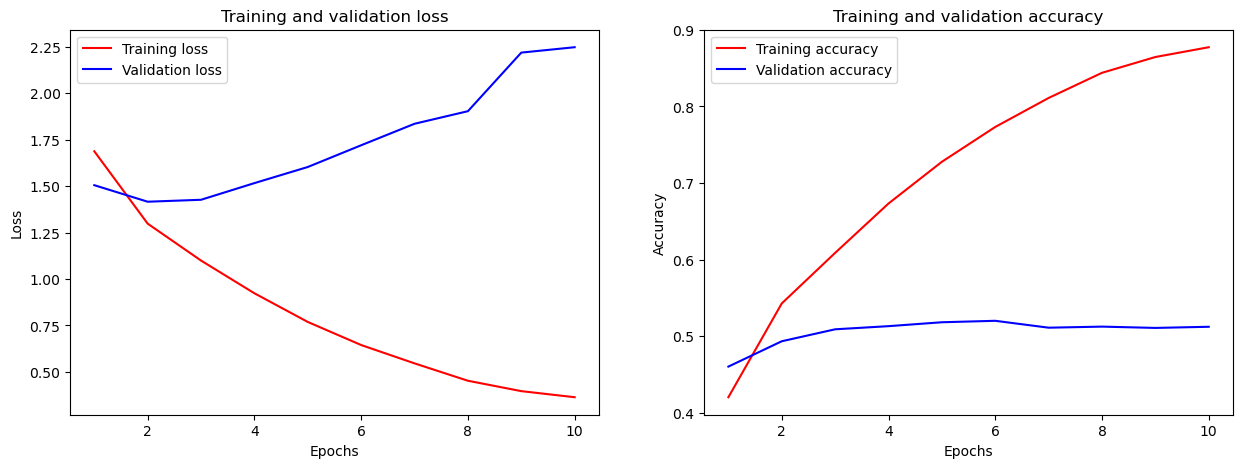

In [39]:
M = X_trn_features.shape[1]

model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(M,)))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_trn_features, y_trn_categorical, batch_size=128, epochs=10, verbose=1, validation_data=(X_tst_features, y_tst_categorical))

loss, accuracy = model.evaluate(X_tst_features, y_tst_categorical, verbose=0)
print('Accuracy:', accuracy)
plot_history(history)